# Leveraging PINNs For Multi-Dimensional Pricing Problems 
#### Author: JP Melo

This thesis is focused on the application of Physics-Informed Neural Networks (PINNs) to solve multi-dimensional pricing problems in finance. The equation we attempt to solve is described below.

### **Equation**
First, we define the scaled variables 
$$
  x_i \;=\; \ln\!\Bigl(\frac{S_i}{K}\Bigr),
  \quad 
  u(\tau, x_1, \dots, x_d) \;=\; \frac{V\bigl(t,S_1,\dots,S_d\bigr)}{K}
  \quad\text{with}\quad 
  \tau \;=\; T - t.
$$

Under risk-neutral pricing in backward time $\tau$, the dimensionless function 
$u(\tau, x_1, \dots, x_d)$ satisfies the PDE
$$
\frac{\partial u}{\partial \tau} \;=\;
\frac{1}{2}\sum_{i=1}^d 
\sigma_i^{2}\!\left(
\frac{\partial^{2}u}{\partial x_i^{2}}
-\frac{\partial u}{\partial x_i}\right)
\;+\;
\frac{1}{2}\sum_{i=1}^d\sum_{j=1}^d
\sigma_i\sigma_j\rho_{ij}\,
\frac{\partial^{2}u}{\partial x_i\,\partial x_j}
\;+\;
r\sum_{i=1}^d\frac{\partial u}{\partial x_i}
\;-\;
r\,u .
$$

### **Boundary Conditions**

**Bottom boundary**  
For very small $S_i$ i.e. $x_i \to -\infty$, one commonly imposes (1 asset)
$$
    -\frac{\partial u}{\partial \tau} - ru \;=\; 0.
$$

For the multi-asset case, the k'th lower boundary condition is given by

$$
\frac{\partial u}{\partial \tau} \;=\;
\frac{1}{2}\sum_{\substack{i=1 \\ i\neq k}}^d 
\sigma_i^{2}\!\left(
\frac{\partial^{2}u}{\partial x_i^{2}}
-\frac{\partial u}{\partial x_i}\right)
\;+\;
\frac{1}{2}\sum_{\substack{i=1 \\ i\neq k}}^d
      \sum_{\substack{j=1 \\ j\neq k}}^d
\sigma_i\sigma_j\rho_{ij}\,
\frac{\partial^{2}u}{\partial x_i\,\partial x_j}
\;+\;
r\sum_{\substack{i=1 \\ i\neq k}}^d
\frac{\partial u}{\partial x_i}
\;-\;
r\,u .
$$

**Top boundary**  
For very large $S_i$ i.e. $x_i \to +\infty$, assume asymptotically linear behavior in $S_i$,
which translates to the following expression in the dimensionless case (1 asset):
$$
   \frac{\partial^2 u}{\partial x_i^2}-\frac{\partial u}{\partial x_i} = 0
$$

The generalization for the multi-asset case is presented below:

$$
\frac{\partial u}{\partial \tau} \;=\;
\frac{1}{2}\sum_{\substack{i=1 \\ i\neq k}}^d 
\sigma_i^{2}\!\left(
\frac{\partial^{2}u}{\partial x_i^{2}}
-\frac{\partial u}{\partial x_i}\right)
\;+\;
\frac{1}{2}\sum_{\substack{i=1 \\ i\neq k}}^d
      \sum_{\substack{j=1 \\ j\neq k}}^d
\sigma_i\sigma_j\rho_{ij}\,
\frac{\partial^{2}u}{\partial x_i\,\partial x_j}
\;+\;
r\sum_{i=1}^d\frac{\partial u}{\partial x_i}
\;-\;
r\,u .
$$

### Imports

In [1]:
from derpinns.nn import *
from derpinns.utils import *
from derpinns.trainer import *
import torch
import kfac

/Users/josemelo/Desktop/master/tesis/codes/.conda/lib/python3.11/site-packages/kfac/base_preconditioner.py:15: UserWarning: NVIDIA Apex is not installed or was not installed with --cpp_ext. Falling back to PyTorch flatten and unflatten.
  from kfac.distributed import get_rank


## Parameters

In [2]:
# Fix seed for reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Global parameters
assets = 2
sampler = "pseudo"               # ["pseudo", "LHS", "Halton", "Hammersley", "Sobol"]:
nn_shape = "10x3"                # n_assets input layer + 64 neurons, 3 hidden layers + 1 output layer
device = torch.device("cpu")     # cpu, cuda or mps
dtype = torch.float32

# Define option valuation params
params = OptionParameters(
    n_assets=assets,
    tau=1.0,
    sigma=np.array([0.2] * assets),
    rho=np.eye(assets) + 0.25 * (np.ones((assets, assets)) - np.eye(assets)),
    r=0.05,
    strike=100,
    payoff=payoff
)

# Build the net to be used
model = build_nn(
    nn_shape=nn_shape,
    input_dim=assets,
    dtype=torch.float32,
    activation=nn.Softplus(),
).apply(weights_init).to(device)

### Other available net models
# model = NNWithAnsatz(n_layers=3, input_dim=assets+1,hidden_dim=32, output_dim=1).apply(weights_init).to(device)
# model = SPINN(n_layers=3, input_dim=assets+1, hidden_dim=32, output_dim=1).apply(weights_init).to(device)
# model = NNWithFourier(n_layers=3, input_dim=assets+1, hidden_dim=64, output_dim=1).apply(weights_init).to(device)

model.train()

NN(
  (hidden_layers): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Softplus(beta=1.0, threshold=20.0)
    (4): Linear(in_features=10, out_features=10, bias=True)
    (5): Softplus(beta=1.0, threshold=20.0)
  )
  (output_layer): Linear(in_features=10, out_features=1, bias=True)
)

## Training

For training, different optimizers are used in order to get better accuracy as stated in [this article](https://arxiv.org/pdf/2402.01868).

### Adam Training

In [3]:

# Set the training parameters
batch_size = 100
total_iter = 200
boundary_samples = 20_000
interior_samples = boundary_samples*assets*2
initial_samples = boundary_samples*assets*2

# Create dataset to traing over
dataset = SampledDataset(
    params, interior_samples, initial_samples, boundary_samples, sampler, dtype, device, seed=0)

# Set optimizer and training function
# 1e-2 is big enought to reach a reasonable min in few steps
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, amsgrad=True)
preconditioner = kfac.preconditioner.KFACPreconditioner(model)

# # Set the training function
closure = DimlessBS()\
    .with_dataset(dataset, loader_opts={'batch_size': batch_size, "shuffle": True, "pin_memory": True})\
    .with_model(model)\
    .with_device(device)\
    .with_dtype(dtype)

trainer = PINNTrainer()\
    .with_optimizer(optimizer)\
    .with_device(device)\
    .with_dtype(dtype)\
    .with_training_step(closure)\
    .with_epochs(total_iter)\
    .with_preconditioner(preconditioner)\

trainer.train()

Adam training: 100%|██████████| 200/200 [01:04<00:00,  3.08it/s, Interior=0.000452, Boundary=0.001859, Initial=0.004394, Total=0.006704, Max Error=133.5758056641, L2 Error=0.2277365774]


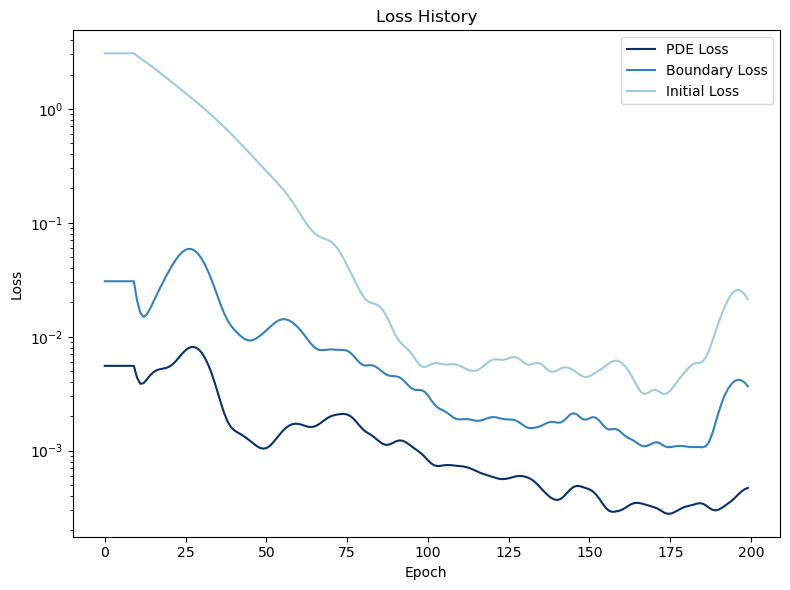

In [4]:
state = trainer.closure.get_state()
plot_loss(state, backend='matplotlib', smooth=True, smooth_window=10)

In [5]:
results = compare_with_mc(model, params, n_prices=200,
                          n_simulations=10_000, dtype=dtype, device=device, seed=42)['l2_rel_error']
print("L2 Error: ", results*100)

L2 Error:  17.93898


### QN Training

SSBroyden training: 100%|██████████| 1000/1000 [07:33<00:00,  2.21it/s, Interior=0.000013, Boundary=0.000007, Initial=0.000017, Total=0.000038, Max Error=1.324707, L2 Error=0.002104]


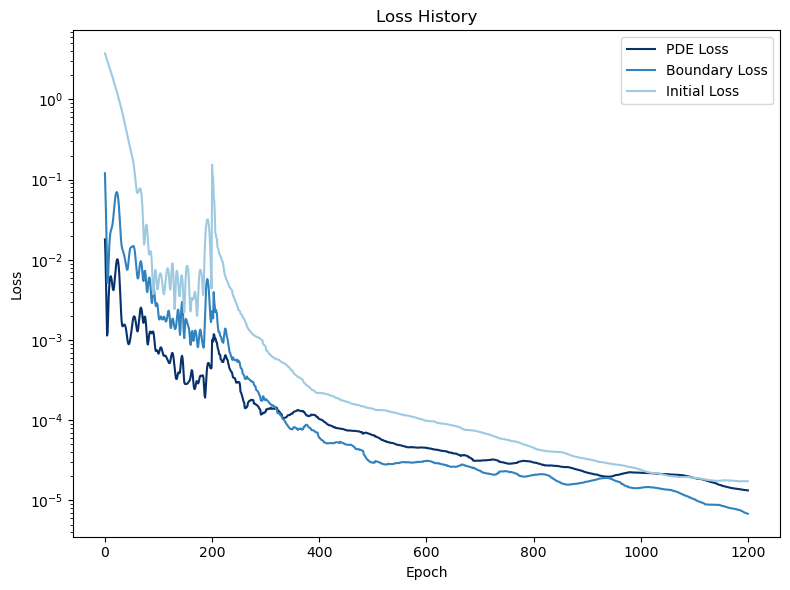

In [6]:
boundary_samples = 500
interior_samples = boundary_samples*assets*2
initial_samples = boundary_samples*assets*2

# We create new samples
dataset = SampledDataset(
    params, interior_samples, initial_samples, boundary_samples, sampler, dtype, device, seed=0)

optimizer = SSBroyden(
    model.parameters(),
    max_iter=1_000,
)
batch_size = len(dataset) # we use all samples

closure = closure.with_dataset(
    dataset, loader_opts={'batch_size': batch_size, "shuffle": False, "pin_memory": True})

trainer = trainer.with_optimizer(optimizer).with_training_step(closure)
trainer.train()

state = closure.get_state()
plot_loss(state, backend='matplotlib', smooth=False)

In [7]:
results = compare_with_mc(model, params, n_prices=200,
                          n_simulations=10_000, dtype=dtype, device=device, seed=42)['l2_rel_error']
print("L2 Error (%): ", results*100)

L2 Error (%):  0.12421205


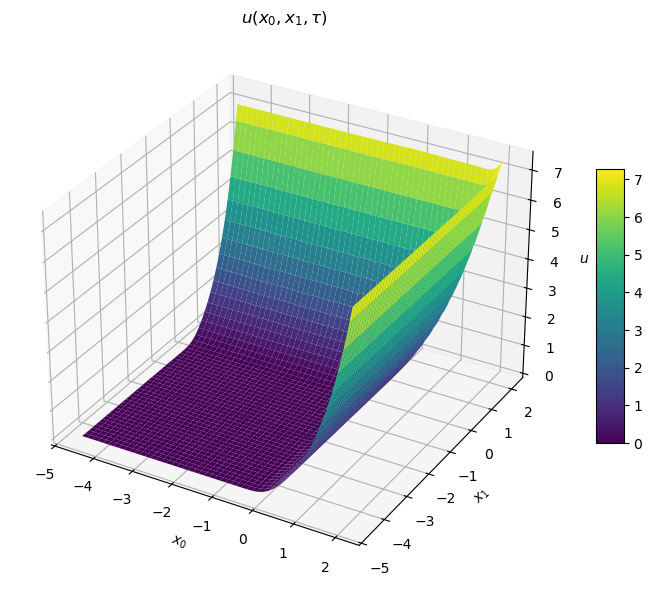

In [10]:
plot_solution_surface(model, params, assets, device, backend='matplotlib')